In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
# Load and preprocess the data
df = pd.read_excel("yahoo_data.xlsx")
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.rename(columns={'Close*': 'Close', 'Adj Close**': 'Adj Close'}, inplace=True)
df.set_index('Date', inplace=True)

In [8]:
# -------------------------------
# Feature Engineering
# -------------------------------
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
df['Volatility'] = df['High'] - df['Low']
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Momentum'] = df['Close'] - df['Close'].shift(5)
df.dropna(inplace=True)

In [9]:
features = ['Close', 'Volume', 'HL_PCT', 'PCT_change', 'MA10', 'Momentum']
target = 'Close'

In [10]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,HL_PCT,PCT_change,Volatility,MA10,MA50,Momentum
Date,,,,,,,,,,,,
2018-07-11,24789.48,24815.16,24663.82,24700.45,24700.45,237370000,0.612701,-0.359144,151.34,24429.697,24657.5980,525.63
2018-07-12,24802.90,24939.97,24802.90,24924.89,24924.89,233150000,0.549932,0.491838,137.07,24510.427,24674.1148,568.15
2018-07-13,24926.07,25043.21,24890.06,25019.41,25019.41,255520000,0.612125,0.374467,153.15,24590.763,24696.0034,562.93
2018-07-16,25025.58,25072.41,24979.64,25064.36,25064.36,231270000,0.370127,0.154961,92.77,24670.058,24718.6876,287.77
2018-07-17,25033.92,25155.39,24989.61,25119.89,25119.89,250450000,0.659955,0.343414,165.78,24751.329,24735.8352,200.23
2018-07-18,25133.79,25215.32,25101.12,25199.29,25199.29,252870000,0.453187,0.260605,114.20,24853.776,24752.6746,498.84
2018-07-19,25139.15,25154.17,25052.62,25064.50,25064.50,285760000,0.405155,-0.296947,101.55,24924.552,24766.7604,139.61
2018-07-20,25041.14,25124.10,24986.35,25058.12,25058.12,274080000,0.549722,0.067808,137.75,24984.716,24777.0720,38.71
2018-07-23,25036.90,25081.45,24983.33,25044.29,25044.29,228820000,0.391786,0.029516,98.12,25011.486,24783.1672,-20.07


In [12]:
# -------------------------------
# Data Scaling
# -------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [13]:
# -------------------------------
# Sequence Generator
# -------------------------------
def create_sequences(data, target_index=0, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, target_index])
    return np.array(X), np.array(y)

time_steps = 90
X, y = create_sequences(scaled_data, time_steps=time_steps)

In [14]:
# -------------------------------
# Train-Test Split
# -------------------------------
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
# -------------------------------
# LSTM Model
# -------------------------------
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,641 (471.25 KB)

 Trainable params: 120,641 (471.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# -------------------------------
# Callbacks
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

In [18]:
# -------------------------------
# Model Training
# -------------------------------
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - loss: 0.0732 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0077 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.0062 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0052 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0037 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 0.0050 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0031 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 0.0034 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.0024 - val_loss: 0.0025 - learning_rate: 0.0010


In [19]:
# -------------------------------
# Prediction and Inverse Scaling
# -------------------------------
y_pred = model.predict(X_test)

# Reconstruct full test set for inverse scaling
close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])
y_test_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = close_scaler.inverse_transform(y_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [20]:
# -------------------------------
# Evaluation
# -------------------------------
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 615.54
RMSE: 778.83


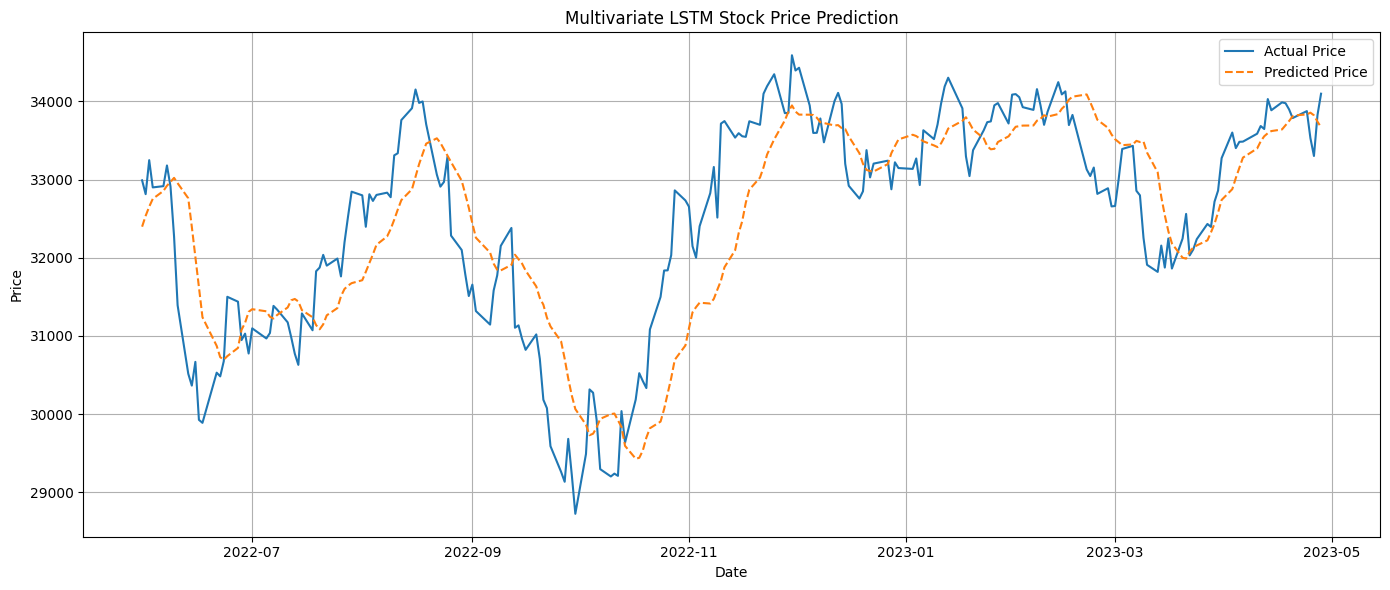

In [21]:
# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(14,6))
plt.plot(df.index[-len(y_test):], y_test_unscaled, label='Actual Price')
plt.plot(df.index[-len(y_test):], y_pred_unscaled, label='Predicted Price', linestyle='--')
plt.title('Multivariate LSTM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()